# Intertest

# Домашняя по git

In [101]:
import pandas as pd
dir = pd.read_excel('Справочник.xlsx')
mar_dt = pd.read_excel('Маркетинговые данные.xlsx')
crm_dt = pd.read_excel('Данные из CRM.xlsx')
course = pd.read_excel('Курсы валют.xlsx')

### 1. Из каких регионов больше всего заявок

In [102]:
mar_dt.loc[mar_dt['City'] != '(not set)'].groupby('City')['Конверсия'].sum().sort_values(ascending=False).head(10)

City
Krasnodar        18246
Sochi             2551
Stavropol         1072
Rostov-on-Don     1049
Moscow            1036
Gelendzhik         654
Voronezh           570
Maykop             326
Grozny             318
Simferopol         297
Name: Конверсия, dtype: int64

### 2. Какой средний процент отказов (Bounce)

In [103]:
print(round(mar_dt['Bounce Rate'].value_counts(normalize=True).loc[1]*100, 2),'%')

0.18 %


### 3. С каких устройств чаще заходят на сайты

In [104]:
mar_dt.groupby('Device Category')['Sessions'].sum().sort_values(ascending=False)

Device Category
mobile     47710
desktop    28857
tablet      2493
Name: Sessions, dtype: int64

### 4. Какие источники наиболее конвертируемые

In [105]:
df = mar_dt.groupby('Source')['Конверсия'].agg(['sum', 'count'])
df['Процент'] = round(df['sum'] / df['count'] * 100, 2)
df[['sum','Процент']].sort_values(by='sum',ascending=False).head(15).rename(columns={'sum': 'Кол-во конверсий'})

,Кол-во конверсий,Процент
Source,,
google,9106,50.31
yandex.ru,5668,49.93
yandex,5035,49.19
(direct),4790,50.83
BMW-keyauto-krd.ru,4151,50.18
google_go_search,1058,50.31
IG,771,48.74
cars.BMW-keyauto-krd.ru,548,46.01
go.mail.ru,399,47.67


### 5. Рассчитайте ROMI (при расчете придумайте методологию расчета средней стоимость проданного автомобиля)

In [106]:
df2 = mar_dt.merge(dir, left_on='Модель', right_on='Модель', how='left')
df2 = df2[(df2['Конверсия'] == 1) & (df2['Маржа (руб)'].notnull())]
df2 = df2.drop_duplicates(subset=['Client ID','Маржа (руб)']).groupby('Client ID')['Маржа (руб)'].mean()
df3 = crm_dt[crm_dt['Продажа'] == 1].groupby('Client ID')['Продажа'].sum()
df4 = pd.merge(df3,df2, on='Client ID', how='left')
avg = df4['Маржа (руб)'].sum()/df4[df4['Маржа (руб)'].notna()]['Продажа'].sum()
df4['Маржа (руб)'] = df4['Маржа (руб)'].fillna(avg)
print('ROMI:', round((df4['Маржа (руб)']*df4['Продажа']).sum()/mar_dt['Goal Value'].sum()*100, 2), '%')

ROMI: 543.9 %


Методология расчёта средней маржи с проданного авто:

Методология основывается на использовании косвенного признака модели автомобиля, вытянутого из столбца "Goal Completion Location".

Для существующих данных по моделям подтянуты значения маржи, после чего отфильтрованы по положительному признаку конверсии и отобраны заходы с уникальными моделями. Итого получаем таблицу, где предположительно имеем для каждого уникального клиента несколько показателей маржи, что соответствует разным моделям машин, одна из которых была приобретена им при наличии признака продажи в таблице "Данные из CRM". По сумме показателей маржи известных моделей для каждого клиента вычисляем среднее значение для предположительного авто.

Из таблицы "Данные из CRM" по признаку продажи считаем количество для каждого ID и объединяем с известными данными из предыдущей таблицы. По существующим совпадениям находим среднюю маржу авто и заполняем ей все пустые значения.

По совокупности всех заполненных данных вычисляем среднюю маржу.

### 6. Посчитайте выручку в рублях только по долларовым позициям

In [107]:
usd_point = mar_dt.merge(dir, left_on='Модель', right_on='Модель', how='left')
usd_point2 = pd.merge(usd_point[usd_point['Валюта'] == 'Доллар США'], crm_dt.groupby('Client ID')['Продажа'].sum(), on='Client ID', how='left').drop_duplicates(subset=['Client ID', 'Модель'])
a = round((usd_point2['Продажа']*usd_point2['Цена (руб)']).sum(), 2)
print(f'{a:,} руб'.replace(',',' '))

1 588 722 952.3 руб


### 7. Определите, какой источник трафика наиболее выгоден для компании по текущим данным

In [108]:
mar_dt['Date'] = pd.to_datetime(mar_dt['Date'])
filter_date = mar_dt[mar_dt['Конверсия'] == 1].groupby('Client ID')['Date'].min()
total_margin = (df4['Маржа (руб)']*df4['Продажа']).to_frame(name='Total Margin').reset_index()
df5 = mar_dt[mar_dt['Конверсия'] == 1].merge(filter_date, how='inner',on=['Client ID','Date'])
filter_avg_dur = df5.groupby('Client ID')['Avg. Session Duration'].max()
filter_source = df5.merge(filter_avg_dur, on=['Client ID','Avg. Session Duration']).drop_duplicates(subset=['Client ID','Source']).drop_duplicates(subset=['Client ID'])
df6 = total_margin.merge(filter_source, on='Client ID', how='inner').groupby('Source')['Total Margin'].sum().reset_index()
final_table = df6.merge(mar_dt.groupby('Source')['Goal Value'].sum(), on=['Source'])
final_table = final_table.merge(df4.merge(filter_source, on='Client ID').groupby('Source')['Продажа'].sum().to_frame(name='Продажа'), on='Source')
final_table['Profit (T-G)'] = final_table['Total Margin'] - final_table['Goal Value']
final_table['Ratio (G/T)'] = final_table['Goal Value']/final_table['Total Margin']*100
final_table.sort_values(by='Profit (T-G)',ascending=False).style.format({'Ratio (G/T)': '{:.1f}%','Total Margin': '{:.2f}','Profit (T-G)': '{:.2f}'})

,Source,Total Margin,Goal Value,Продажа,Profit (T-G),Ratio (G/T)
17,google,1320685717.72,241050838,1115,1079634879.72,18.3%
32,yandex.ru,840831373.46,149605645,715,691225728.46,17.8%
0,(direct),724616598.77,127409840,612,597206758.77,17.6%
28,yandex,725438769.84,133076623,589,592362146.84,18.3%
2,BMW-keyauto-krd.ru,612706765.19,111141166,552,501565599.19,18.1%
19,google_go_search,153399793.97,27905527,141,125494266.97,18.2%
14,cars.BMW-keyauto-krd.ru,70857299.52,14606107,64,56251192.52,20.6%
8,IG,65163194.93,20818551,77,44344643.93,31.9%
9,Mersedes.ru,53532092.02,9315685,45,44216407.02,17.4%
15,carsdo.ru,53294746.26,9786066,55,43508680.26,18.4%


### 8. Ответьте на вопрос: каких показателей не хватает, чтобы посчитать чистую прибыль?

Всех. Нет ни расходов, ни доходов. Есть только "маржа", не понятно на каком этапе рассчитанная, и расходы на рекламу через интернет-ресурсы, которые тоже вызвали вопросы, требующие уточнений, при анализе источников.

### 9. Сделать прогноз до конца февраля по количеству конверсий на каждый день

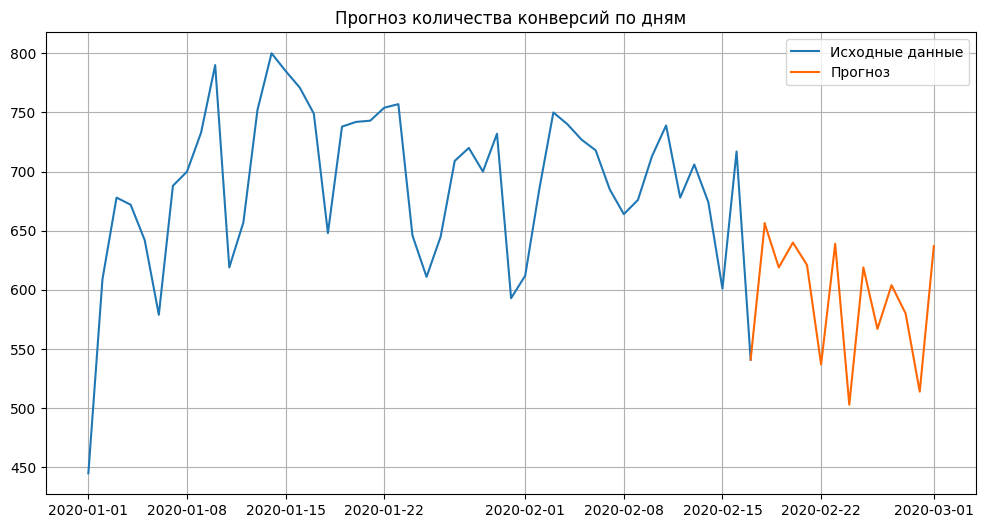

2020-02-18    656.0
2020-02-19    619.0
2020-02-20    640.0
2020-02-21    621.0
2020-02-22    537.0
2020-02-23    639.0
2020-02-24    503.0
2020-02-25    619.0
2020-02-26    567.0
2020-02-27    604.0
2020-02-28    580.0
2020-02-29    514.0
2020-03-01    637.0
Freq: D, Name: predicted_mean, dtype: float64


In [109]:
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

mar_dt['Date'] = pd.to_datetime(mar_dt['Date'])
cur_date = mar_dt.groupby('Date')['Конверсия'].sum().to_frame()
model = SARIMAX(cur_date['Конверсия'], order=(1, 0, 1), seasonal_order=(1, 1, 1, 7)).fit()
forecast = model.forecast(steps=13)
forecast = round(forecast)


plt.figure(figsize=(12,6))
plt.plot(cur_date.index, cur_date['Конверсия'], label='Исходные данные')
plt.plot(forecast.index, forecast.values, label='Прогноз', color='#FF6600')
plt.plot([cur_date.index[-1], forecast.index[0]], [cur_date['Конверсия'].iloc[-1], forecast.values[0]], color='#FF6600')
plt.title('Прогноз количества конверсий по дням')
plt.legend()
plt.grid()
plt.show()

print(forecast)


### 10. Какая будет выручка за первый квартал, если средняя стоимость авто останется неизменной, а продажи будут пропорциональны текущим данным?

In [110]:
from datetime import datetime
price = mar_dt.merge(dir, left_on='Модель', right_on='Модель', how='left')
price = price[(price['Конверсия'] == 1) & (price['Цена (руб)'].notnull())]
price = price.drop_duplicates(subset=['Client ID','Цена (руб)']).groupby('Client ID')['Цена (руб)'].mean()
price2 = crm_dt[crm_dt['Продажа'] == 1].groupby('Client ID')['Продажа'].sum()
price3 = pd.merge(price2,price, on='Client ID', how='left')
avg_price = price3['Цена (руб)'].sum()/price3[price3['Цена (руб)'].notna()]['Продажа'].sum()
price3['Цена (руб)'] = price3['Цена (руб)'].fillna(avg_price)
total_revenue = (price3['Цена (руб)']*price3['Продажа']).sum()
b = total_revenue*(datetime.strptime('1/4/2020', '%d/%m/%Y')-datetime.strptime('1/1/2020', '%d/%m/%Y')).days/(datetime.strptime('18/2/2020', '%d/%m/%Y')-datetime.strptime('1/1/2020', '%d/%m/%Y')).days
print(f'{round(b,2):,} руб'.replace(',',' ')) 

33 146 912 845.44 руб
